In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
pd.options.display.max_columns = 999

In [35]:
from sklearn.preprocessing import LabelBinarizer

## Binary classification of income with gradient boosting

Source: http://archive.ics.uci.edu/ml/datasets/Adult

- Label: 
    - \>50K, <=50K.


- Features:
    - age: continuous.
    - workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
    - fnlwgt: continuous.
    - education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
    - education-num: continuous.
    - marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
    - occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
    - relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
    - race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
    - sex: Female, Male.
    - capital-gain: continuous.
    - capital-loss: continuous.
    - hours-per-week: continuous.
    - native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

    Description of fnlwgt (final weight)

    The weights on the CPS files are controlled to independent estimates of the
    civilian noninstitutional population of the US.  These are prepared monthly
    for us by Population Division here at the Census Bureau.  We use 3 sets of
    controls.
     These are:
             1.  A single cell estimate of the population 16+ for each state.
             2.  Controls for Hispanic Origin by age and sex.
             3.  Controls by Race, age and sex.

    We use all three sets of controls in our weighting program and "rake" through
    them 6 times so that by the end we come back to all the controls we used.
    The term estimate refers to population totals derived from CPS by creating
    "weighted tallies" of any specified socio-economic characteristics of the
    population.

    People with similar demographic characteristics should have
    similar weights.  There is one important caveat to remember
    about this statement.  That is that since the CPS sample is
    actually a collection of 51 state samples, each with its own
    probability of selection, the statement only applies within
    state.

fnlwgt doesn't seem very interpretable so I will consider dropping it further down.

In [27]:
adult_names = [
    "age",
    "workclass",
    "fnlwgt",
    "education",
    "education_num",
    "marital-status",
    "occupation",
    "relationship",
    "race",
    "sex",
    "capital-gain",
    "capital-loss",
    "hours-per-week",
    "native-country",
    "income",
]

In [99]:
adult_data = pd.read_csv(f"../data/adult.data", header=None)

In [100]:
adult_data.columns = adult_names

In [101]:
adult_data.isna().any()

age               False
workclass         False
fnlwgt            False
education         False
education_num     False
marital-status    False
occupation        False
relationship      False
race              False
sex               False
capital-gain      False
capital-loss      False
hours-per-week    False
native-country    False
income            False
dtype: bool

### Interrogating some of the non-obvious variables

- fnlwgt: "Final weight"

<AxesSubplot:>

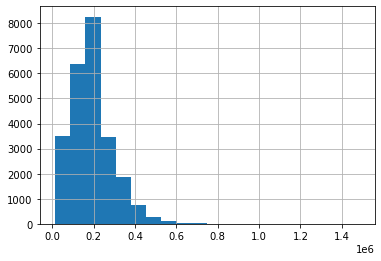

In [102]:
adult_data.query("income==' <=50K'")["fnlwgt"].hist(bins=20)

<AxesSubplot:>

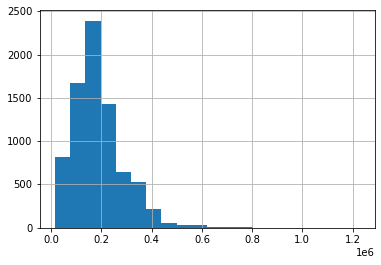

In [103]:
adult_data.query("income==' >50K'")["fnlwgt"].hist(bins=20)

-  capital-gain

<AxesSubplot:>

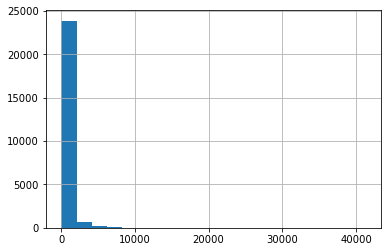

In [95]:
adult_data.query("income==' <=50K'")["capital-gain"].hist(bins=20)

<AxesSubplot:>

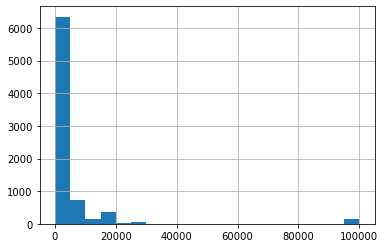

In [96]:
adult_data.query("income==' >50K'")["capital-gain"].hist(bins=20)

- capital-loss

<AxesSubplot:>

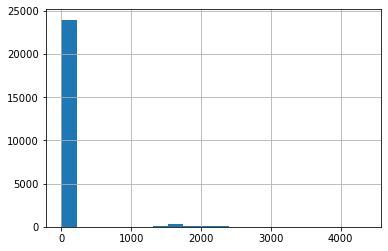

In [92]:
adult_data.query("income==' <=50K'")["capital-loss"].hist(bins=20)

<AxesSubplot:>

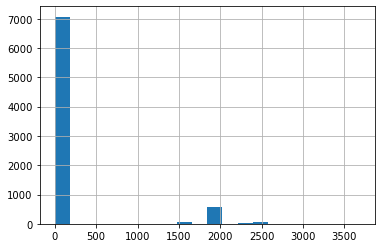

In [93]:
adult_data.query("income==' >50K'")["capital-loss"].hist(bins=20)

The meaning of capital-gain and capital-loss are somewhat opaque beyond what you can infer (maybe their definitions are gains or losses on capital investments for that year of 2004), so including them seems somewhat dubious. But capital-gain in particular seems to be a discriminating variable between the two classes on the right tail, which makes sense according to the inferred definition as people with higher incomes are more likely to invest and get capital gains.

"Final weight" on the other hand doesn't seem very predictive at all.

In [108]:
adult_data.drop(columns=["fnlwgt"], inplace=True)

In [109]:
adult_data.head()

,age,workclass,education,education_num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
adult_data

#### One-hot encode categorical variables

In [129]:
one_hot_dfs = []
one_hot_cols = [  # Columns to one-hot encode
    "workclass",
    "marital-status",
    "occupation",
    "relationship",
    "race", 
    "sex",
    
]

for c in one_hot_cols:
    one_hot = LabelBinarizer()
    one_hot_df = pd.DataFrame(one_hot.fit_transform(adult_data[c]))
    if len(one_hot.classes_) == 2:
        one_hot_df.columns = one_hot.classes_[1:]
    else:
        one_hot_df.columns = one_hot.classes_
    one_hot_dfs.append(one_hot_df)

adult_data_one_hot = pd.concat(
    [adult_data[
        [c for c in adult_data.columns if c not in ["education"] + one_hot_cols]
    ]]
    + one_hot_dfs, 
    axis="columns"
)

Taking a look at the frequencies in the categorical variables - and the label - before one-hot encoding:

In [120]:
for c in one_hot_cols + ["income"]:
    print(adult_data[c].value_counts())
    print("\n")

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64


 Married-civ-spouse       14976
 Never-married            10683
 Divorced                  4443
 Separated                 1025
 Widowed                    993
 Married-spouse-absent      418
 Married-AF-spouse           23
Name: marital-status, dtype: int64


 Prof-specialty       4140
 Craft-repair         4099
 Exec-managerial      4066
 Adm-clerical         3770
 Sales                3650
 Other-service        3295
 Machine-op-inspct    2002
 ?                    1843
 Transport-moving     1597
 Handlers-cleaners    1370
 Farming-fishing       994
 Tech-support          928
 Protective-serv       649
 Priv-house-serv       149
 Armed-Forces            9
Name: occupation, dtype: int64


 Husband           13193
 

In [122]:
adult_data_one_hot.head()

,age,education_num,capital-gain,capital-loss,hours-per-week,native-country,income,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,Male,?,Federal-gov,Local-gov,Never-worked,Private,Self-emp-inc,Self-emp-not-inc,State-gov,Without-pay,Divorced,Married-AF-spouse,Married-civ-spouse,Married-spouse-absent,Never-married,Separated,Widowed,?,Adm-clerical,Armed-Forces,Craft-repair,Exec-managerial,Farming-fishing,Handlers-cleaners,Machine-op-inspct,Other-service,Priv-house-serv,Prof-specialty,Protective-serv,Sales,Tech-support,Transport-moving,Husband,Not-in-family,Other-relative,Own-child,Unmarried,Wife,Amer-Indian-Eskimo,Asian-Pac-Islander,Black,Other,White,Male
0,39,13,2174,0,40,United-States,<=50K,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
1,50,13,0,0,13,United-States,<=50K,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
2,38,9,0,0,40,United-States,<=50K,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1
3,53,7,0,0,40,United-States,<=50K,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1
4,28,13,0,0,40,Cuba,<=50K,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0


#### Brief descriptive statistics

We may want to sniff out some unexpected/unusual correlations between the features at this stage

In [130]:
correlation_mat = adult_data_one_hot.corr()

<AxesSubplot:>

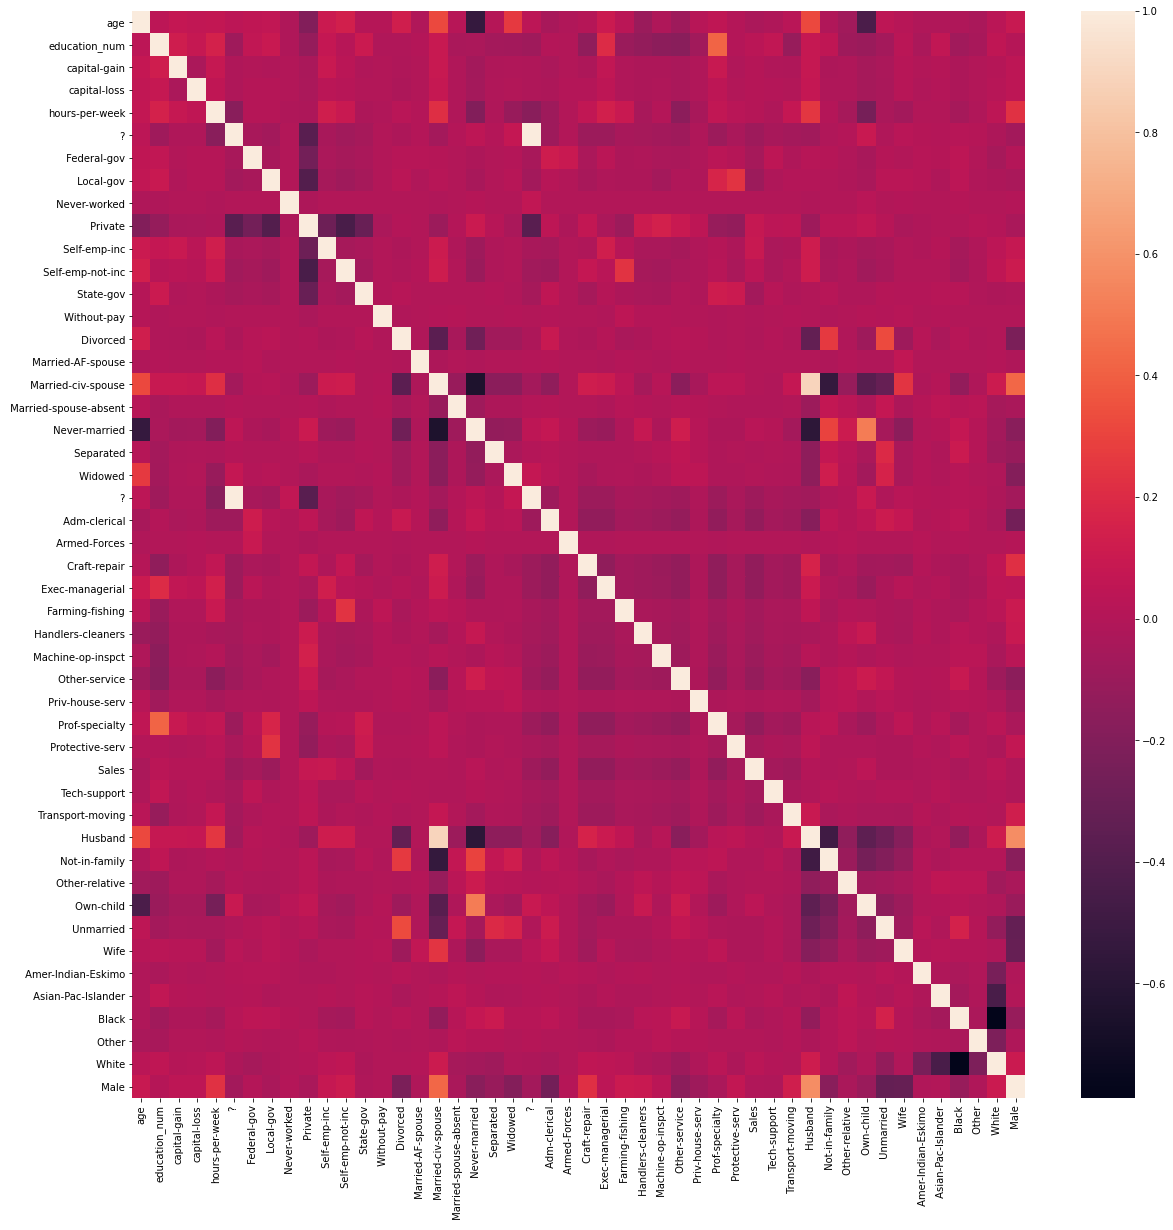

In [133]:
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlation_mat, annot = False)  # Plot too tight to annotate with visible numeric values

Couple points:
- There are clusters of large correlations in absolute value, but these are between expected categories like relationship and marital status
- Age has strong negative correlation with Never-married and Unmarried, which is also expected
- Workclass is always unknown (marked as "?") when occupation is unknown, which is good
- Otherwise, there are not really any other unexpectedly strong correlations